In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -*- coding: utf-8 -*-
import os
import time
import copy
import gc

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.cuda import empty_cache

# Vision and data processing
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets.folder import IMG_EXTENSIONS

# Data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Image processing
import cv2
import PIL
import numpy as np

In [ ]:
# Ensure compatibility with .jpg files
IMG_EXTENSIONS = ('.jpg', '.jpeg')

def get_model_config(model_name):
    """Return model-specific configuration."""
    configs = {
        "resnet18": {
            "batch_size": 32,
            "image_size": 224
        },
        "vgg16": {
            "batch_size": 24,
            "image_size": 224
        },
        "inception": {
            "batch_size": 24,
            "image_size": 299  # Inception requires 299x299 input
        },
        "mobilenet": {
            "batch_size": 32,
            "image_size": 224
        }
    }
    return configs[model_name]

In [ ]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    """Initialize model with specified architecture."""
    model = None

    if model_name == "resnet18":
        model = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg16":
        model = models.vgg16(pretrained=use_pretrained)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "inception":
        model = models.inception_v3(pretrained=use_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.aux_logits = False  # Disable auxiliary output

    elif model_name == "mobilenet":
        model = models.mobilenet_v2(pretrained=use_pretrained)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    return model


In [ ]:
def load_dataset(data_dir, model_name):
    """Load dataset with model-specific transformations."""
    config = get_model_config(model_name)
    image_size = config["image_size"]
    batch_size = config["batch_size"]

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x])
                     for x in ['train', 'val']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=2)
                   for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    return dataloaders, dataset_sizes, class_names

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    """Train the model and return both the best model and training history."""
    since = time.time()
    device = next(model.parameters()).device

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

    return model, history

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model and return predictions, true labels, and metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return all_preds, all_labels, epoch_loss, epoch_acc

def plot_confusion_matrix(true_labels, predictions, class_names, title):
    """Plot confusion matrix using seaborn."""
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
def train_all_models(data_dir, save_dir, sam, num_epochs=15):
    """Train and evaluate multiple models."""
    models_to_train = []
    models_to_train.append(sam)
    results = {}

    for model_name in models_to_train:
        print(f"\nTraining {model_name}...")

        empty_cache()
        gc.collect()

        try:
            dataloaders, dataset_sizes, class_names = load_dataset(data_dir, model_name)

            model = initialize_model(model_name, len(class_names))
            model = model.to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
            scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            model, train_history = train_model(
                model, criterion, optimizer, scheduler,
                dataloaders, dataset_sizes, num_epochs
            )

            val_preds, val_labels, val_loss, val_acc = evaluate_model(
                model, dataloaders['val'], criterion, device
            )

            print("\nClassification Report:")
            print(classification_report(val_labels, val_preds,
                                     target_names=class_names))

            plot_confusion_matrix(
                val_labels, val_preds, class_names,
                f'Confusion Matrix - {model_name}'
            )

            save_path = os.path.join(save_dir, f'{model_name}_model.pth')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_history': train_history,
                'class_names': class_names
            }, save_path)

            results[model_name] = {
                'val_acc': val_acc.item(),
                'val_loss': val_loss,
                'train_history': train_history
            }

        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")
            continue

        del model
        empty_cache()
        gc.collect()

    if results:
        plt.figure(figsize=(12, 6))
        for model_name, data in results.items():
            plt.plot(data['train_history']['val_acc'], label=f'{model_name}')
        plt.title('Validation Accuracy Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

In [ ]:
def test_multiple_models(image_path, save_dir, class_names):
    """Test a single image on all saved models."""
    models_to_test = ["resnet18", "vgg16", "inception", "mobilenet"]
    results = {}

    for model_name in models_to_test:
        try:
            config = get_model_config(model_name)
            image_size = config["image_size"]

            preprocess = transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            image = PIL.Image.open(image_path).convert('RGB')
            image_tensor = preprocess(image).unsqueeze(0).to(device)

            checkpoint = torch.load(os.path.join(save_dir, f'{model_name}_model.pth'))
            model = initialize_model(model_name, len(class_names))
            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)
            model.eval()

            with torch.no_grad():
                outputs = model(image_tensor)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)

            predicted_class = class_names[preds[0]]
            confidence = probabilities[0][preds[0]].item()

            results[model_name] = {
                'predicted_class': predicted_class,
                'confidence': confidence
            }

            del model
            empty_cache()
            gc.collect()

        except Exception as e:
            print(f"Error testing {model_name}: {str(e)}")
            continue

    for model_name, result in results.items():
        print(f"\n{model_name}:")
        print(f"Predicted Class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.2%}")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
# Set up directories
data_dir = '/content/drive/MyDrive/BTP-Brain tumour'
save_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(save_dir, exist_ok=True)




Training resnet18...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Epoch 0/14
----------
train Loss: 0.5413 Acc: 0.7781
val Loss: 0.3420 Acc: 0.8637

Epoch 1/14
----------
train Loss: 0.2199 Acc: 0.9254
val Loss: 0.2193 Acc: 0.9038

Epoch 2/14
----------
train Loss: 0.1411 Acc: 0.9524
val Loss: 0.1783 Acc: 0.9379

Epoch 3/14
----------
train Loss: 0.0870 Acc: 0.9744
val Loss: 0.1578 Acc: 0.9379

Epoch 4/14
----------
train Loss: 0.0705 Acc: 0.9815
val Loss: 0.1510 Acc: 0.9399

Epoch 5/14
----------
train Loss: 0.0511 Acc: 0.9855
val Loss: 0.1291 Acc: 0.9519

Epoch 6/14
----------
train Loss: 0.0280 Acc: 0.9950
val Loss: 0.1244 Acc: 0.9579

Epoch 7/14
----------
train Loss: 0.0255 Acc: 0.9960
val Loss: 0.1273 Acc: 0.9559

Epoch 8/14
----------
train Loss: 0.0232 Acc: 0.9950
val Loss: 0.1246 Acc: 0.9599

Epoch 9/14
----------
train Loss: 0.0213 Acc: 0.9955
val Loss: 0.1227 Acc: 0.9639

Epoch 10/14
----------
train Loss: 0.0216 Acc: 0.9955
val Loss: 0.1243 Acc: 0.9539

Epoch 11/14
----------
train Loss: 0.0206 Acc: 0.9965
val Loss: 0.1203 Acc: 0.9619

Ep

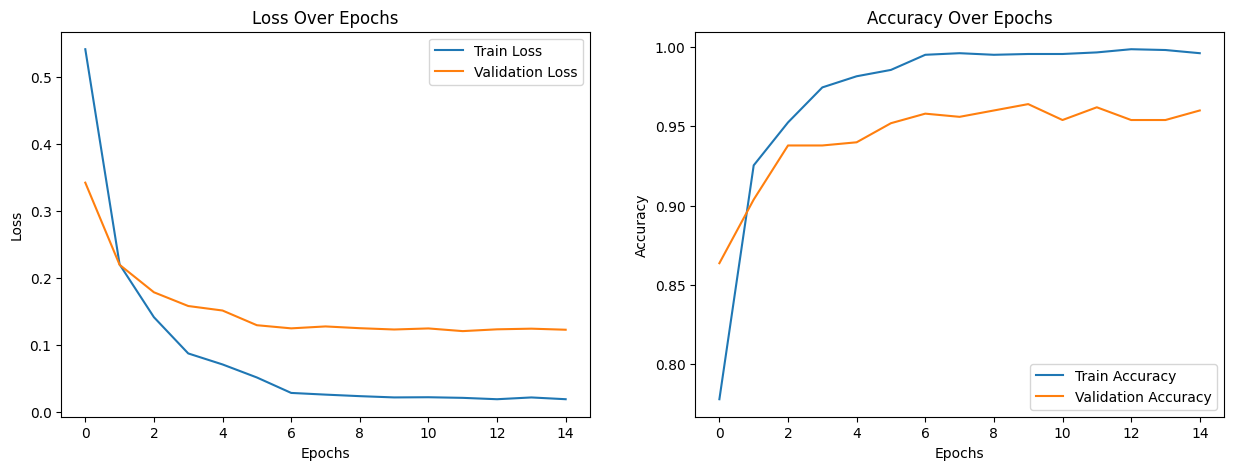


Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.95      0.95       165
           2       0.98      0.98      0.98       168
           3       0.97      0.96      0.97       166

    accuracy                           0.96       499
   macro avg       0.96      0.96      0.96       499
weighted avg       0.96      0.96      0.96       499



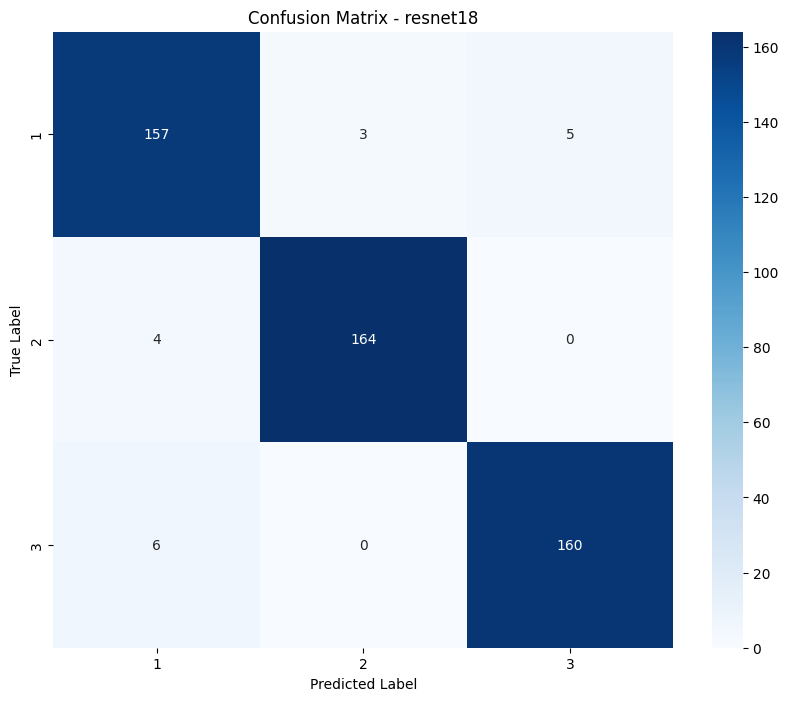

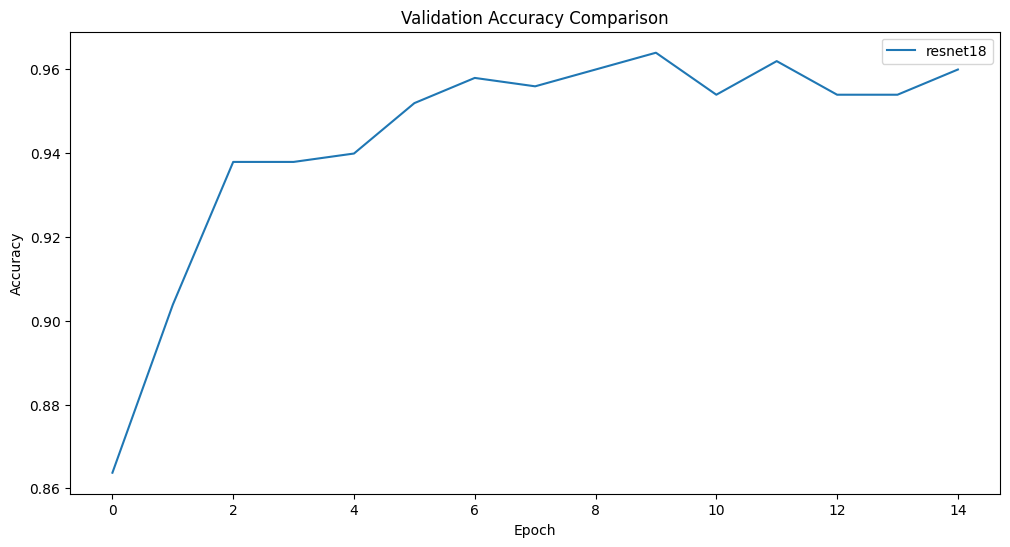

In [ ]:
# Train all models "resnet18", "vgg16", "inception", "mobilenet"
train_all_models(data_dir, save_dir, "resnet18")



Training vgg16...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.6MB/s]


Epoch 0/14
----------
train Loss: 0.5331 Acc: 0.7610
val Loss: 0.3136 Acc: 0.8778

Epoch 1/14
----------
train Loss: 0.2537 Acc: 0.9073
val Loss: 0.2448 Acc: 0.9058

Epoch 2/14
----------
train Loss: 0.1845 Acc: 0.9334
val Loss: 0.1840 Acc: 0.9178

Epoch 3/14
----------
train Loss: 0.1373 Acc: 0.9549
val Loss: 0.1404 Acc: 0.9479

Epoch 4/14
----------
train Loss: 0.0910 Acc: 0.9679
val Loss: 0.1371 Acc: 0.9499

Epoch 5/14
----------
train Loss: 0.0416 Acc: 0.9880
val Loss: 0.1009 Acc: 0.9659

Epoch 6/14
----------
train Loss: 0.0497 Acc: 0.9830
val Loss: 0.1008 Acc: 0.9579

Epoch 7/14
----------
train Loss: 0.0119 Acc: 0.9980
val Loss: 0.0894 Acc: 0.9639

Epoch 8/14
----------
train Loss: 0.0088 Acc: 0.9985
val Loss: 0.0960 Acc: 0.9659

Epoch 9/14
----------
train Loss: 0.0062 Acc: 0.9995
val Loss: 0.0917 Acc: 0.9619

Epoch 10/14
----------
train Loss: 0.0067 Acc: 0.9980
val Loss: 0.1000 Acc: 0.9659

Epoch 11/14
----------
train Loss: 0.0063 Acc: 0.9985
val Loss: 0.0970 Acc: 0.9639

Ep

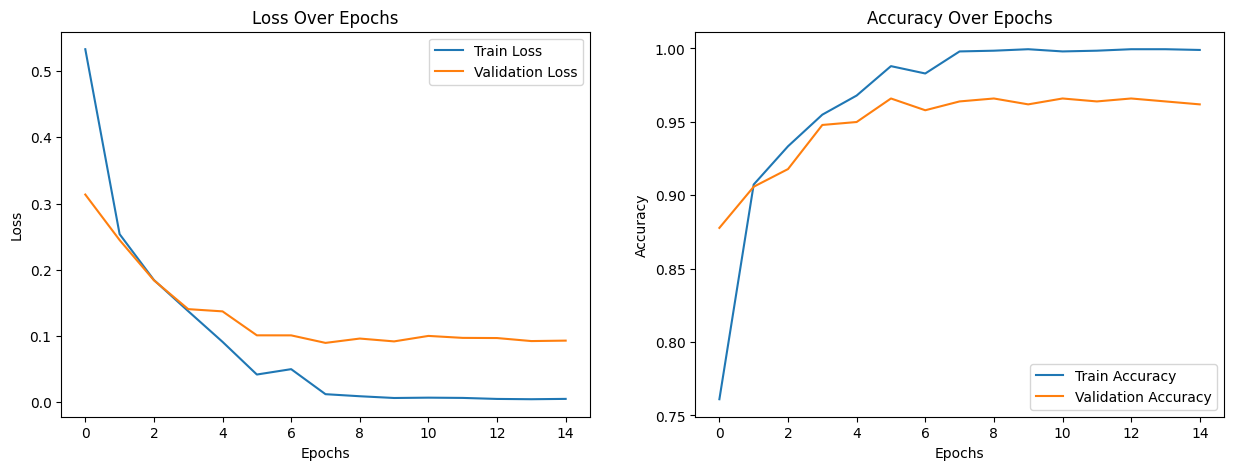


Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.96      0.95       165
           2       0.99      0.97      0.98       168
           3       0.98      0.96      0.97       166

    accuracy                           0.97       499
   macro avg       0.97      0.97      0.97       499
weighted avg       0.97      0.97      0.97       499



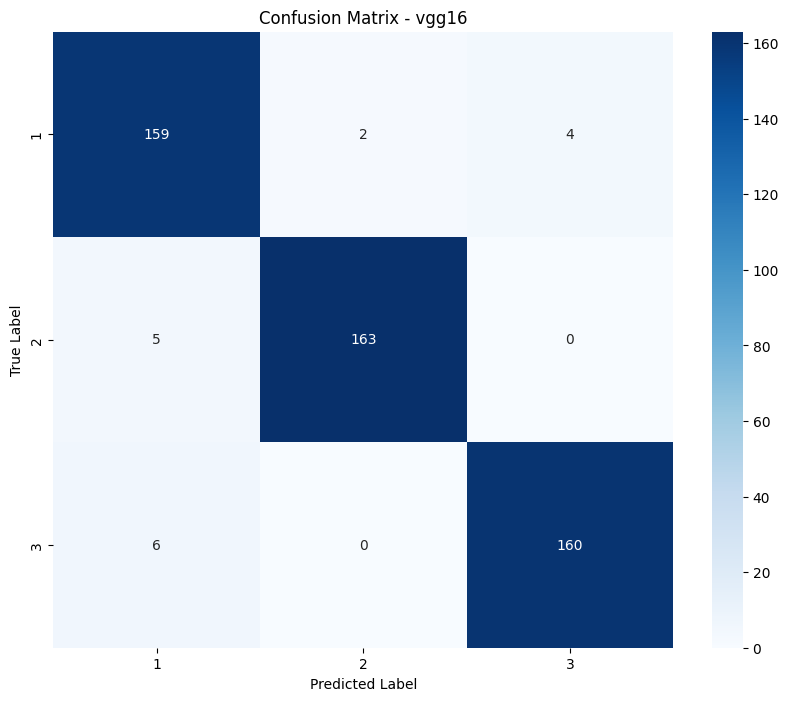

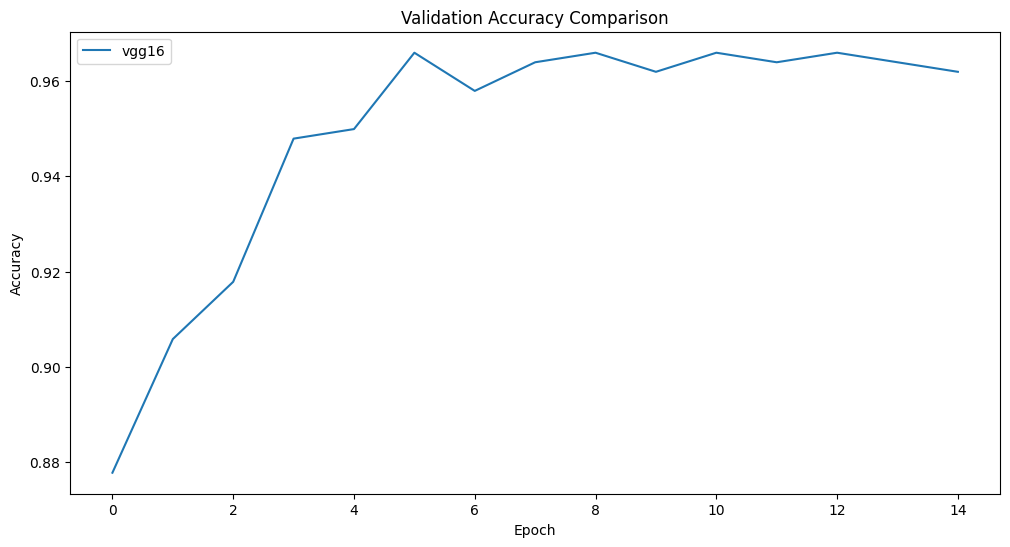

In [ ]:
train_all_models(data_dir, save_dir, "vgg16")


Training mobilenet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 102MB/s] 

Epoch 0/14
----------


train Loss: 0.5676 Acc: 0.7590
val Loss: 0.2428 Acc: 0.9178

Epoch 1/14
----------
train Loss: 0.2197 Acc: 0.9138
val Loss: 0.1698 Acc: 0.9479

Epoch 2/14
----------
train Loss: 0.1407 Acc: 0.9484
val Loss: 0.1531 Acc: 0.9519

Epoch 3/14
----------
train Loss: 0.0843 Acc: 0.9699
val Loss: 0.1238 Acc: 0.9579

Epoch 4/14
----------
train Loss: 0.0429 Acc: 0.9880
val Loss: 0.1092 Acc: 0.9659

Epoch 5/14
----------
train Loss: 0.0300 Acc: 0.9925
val Loss: 0.1275 Acc: 0.9539

Epoch 6/14
----------
train Loss: 0.0327 Acc: 0.9910
val Loss: 0.1238 Acc: 0.9599

Epoch 7/14
----------
train Loss: 0.0190 Acc: 0.9965
val Loss: 0.1166 Acc: 0.9619

Epoch 8/14
----------
train Loss: 0.0194 Acc: 0.9950
val Loss: 0.1310 Acc: 0.9599

Epoch 9/14
----------
train Loss: 0.0237 Acc: 0.9925
val Loss: 0.1099 Acc: 0.9699

Epoch 10/14
----------
train Loss: 0.0162 Acc: 0.9980
val Loss: 0.1088 Acc: 0.9679

Epoch 11/14
----------
train Loss: 0.0170 Acc: 0.9950
val Loss: 0.1061 Acc: 0.9679

Epoch 12/14
----------
t

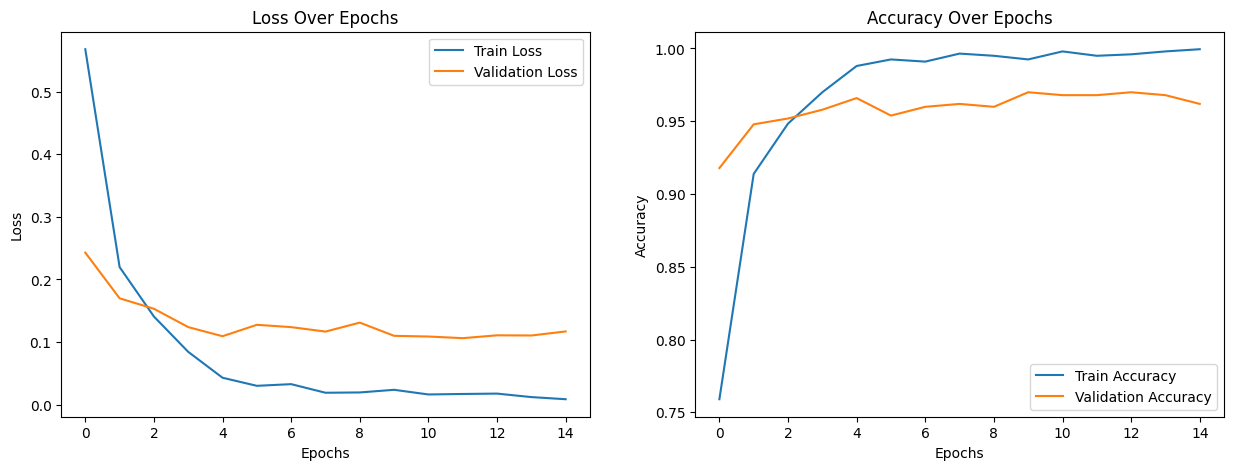


Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.98      0.96       165
           2       0.99      0.95      0.97       168
           3       0.99      0.98      0.98       166

    accuracy                           0.97       499
   macro avg       0.97      0.97      0.97       499
weighted avg       0.97      0.97      0.97       499



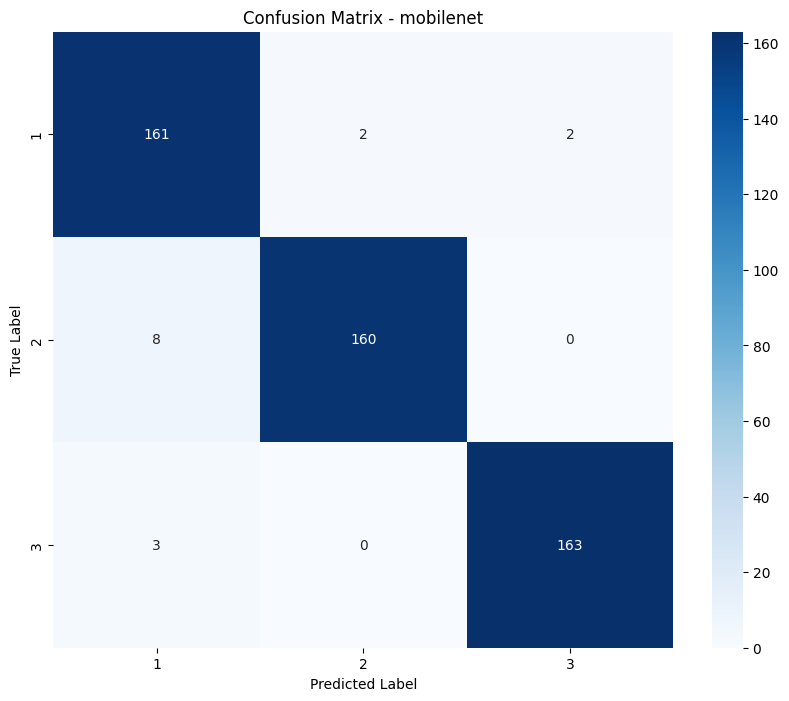

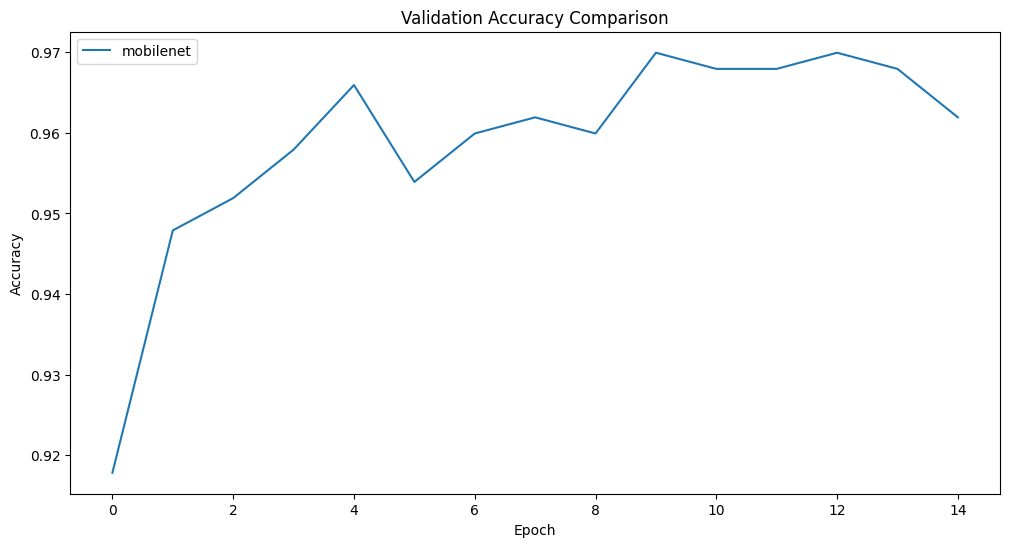

In [ ]:
train_all_models(data_dir, save_dir, "mobilenet")


Training inception...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 180MB/s] 


Epoch 0/14
----------
train Loss: 0.6900 Acc: 0.7019
val Loss: 0.2942 Acc: 0.9158

Epoch 1/14
----------
train Loss: 0.2373 Acc: 0.9133
val Loss: 0.2194 Acc: 0.9158

Epoch 2/14
----------
train Loss: 0.1314 Acc: 0.9569
val Loss: 0.1837 Acc: 0.9319

Epoch 3/14
----------
train Loss: 0.0736 Acc: 0.9790
val Loss: 0.1379 Acc: 0.9539

Epoch 4/14
----------
train Loss: 0.0606 Acc: 0.9805
val Loss: 0.1351 Acc: 0.9479

Epoch 5/14
----------
train Loss: 0.0598 Acc: 0.9820
val Loss: 0.1048 Acc: 0.9619

Epoch 6/14
----------
train Loss: 0.0389 Acc: 0.9915
val Loss: 0.1274 Acc: 0.9599

Epoch 7/14
----------
train Loss: 0.0279 Acc: 0.9935
val Loss: 0.1225 Acc: 0.9579

Epoch 8/14
----------
val Loss: 0.1220 Acc: 0.9599

Epoch 9/14
----------
train Loss: 0.0174 Acc: 0.9985
val Loss: 0.1448 Acc: 0.9559

Epoch 10/14
----------
train Loss: 0.0167 Acc: 0.9975
val Loss: 0.1238 Acc: 0.9579

Epoch 11/14
----------
train Loss: 0.0214 Acc: 0.9955
val Loss: 0.1108 Acc: 0.9599

Epoch 12/14
----------
train Loss

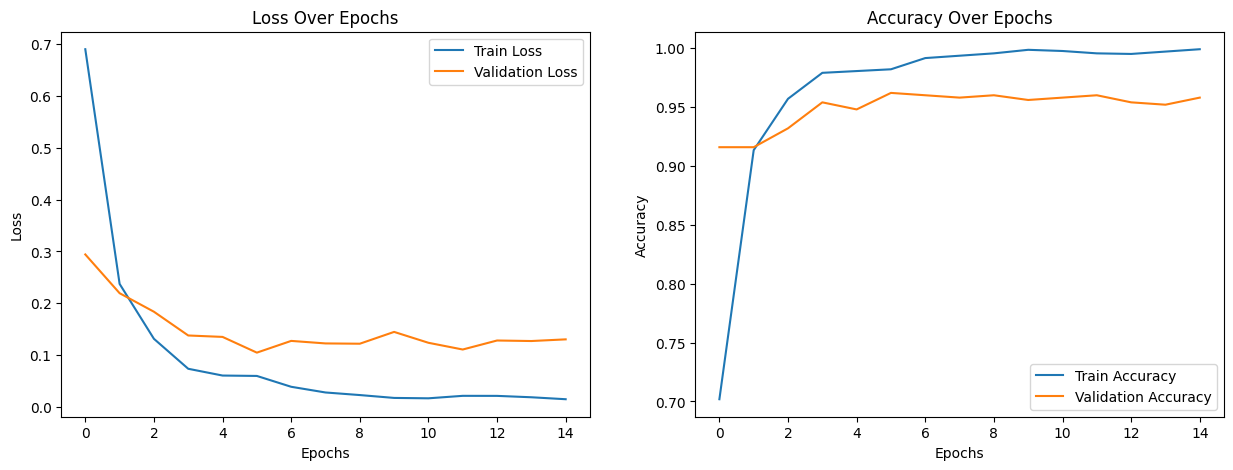


Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.96      0.94       165
           2       0.98      0.96      0.97       168
           3       0.99      0.96      0.97       166

    accuracy                           0.96       499
   macro avg       0.96      0.96      0.96       499
weighted avg       0.96      0.96      0.96       499



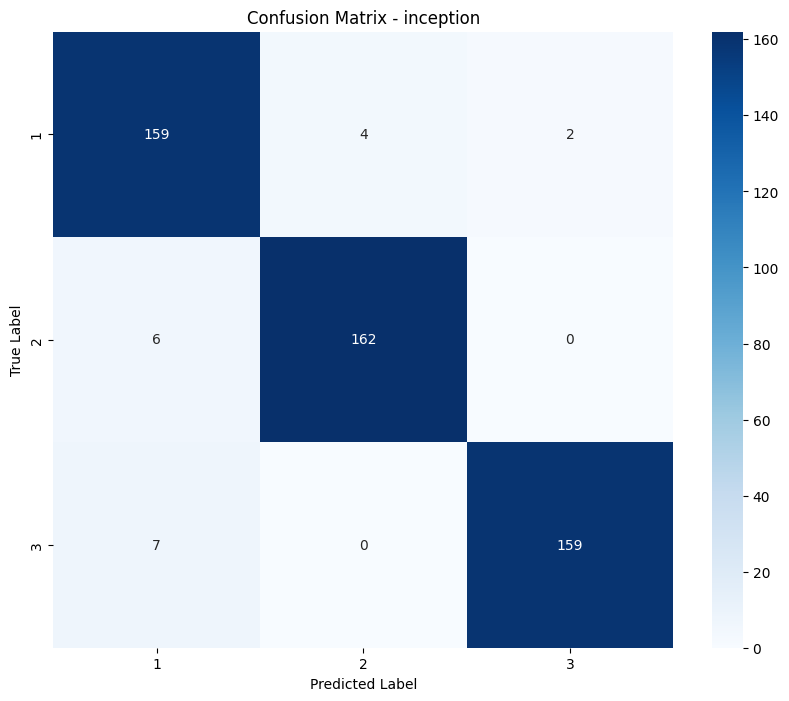

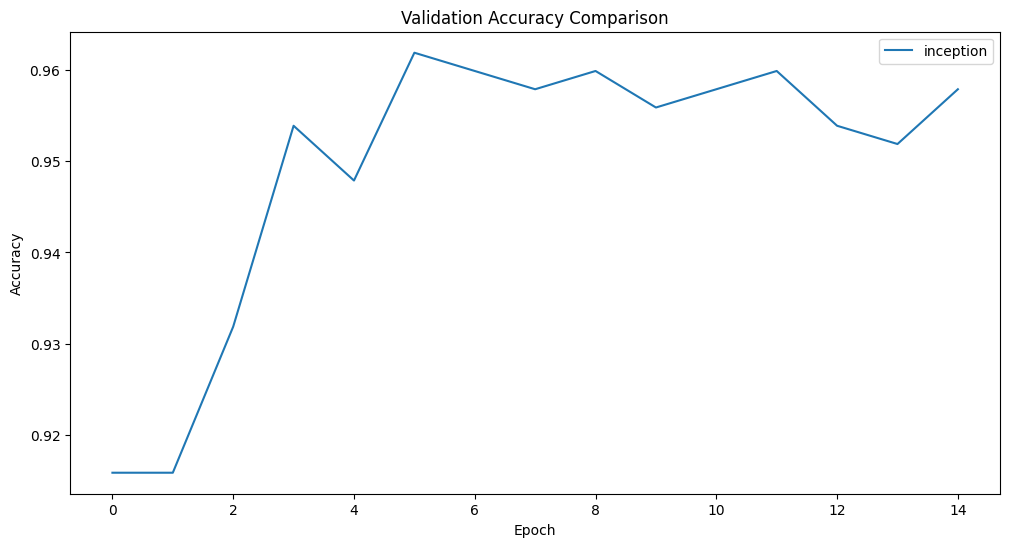

In [ ]:
train_all_models(data_dir, save_dir, "inception")

In [ ]:

# Test on a specific image
image_path = input("Enter image path: ")
class_names = ['glioma_tumor', 'meningioma_tumor','pituitary_tumor']
test_multiple_models(image_path, save_dir, class_names)

Enter image path: /content/drive/MyDrive/BTP-Brain tumour/val/2/gg (126).jpg


<ipython-input-9-58a1464f96ce>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(save_dir, f'{model_name}_model.pth'))
/usr/local/lib/py


resnet18:
Predicted Class: meningioma_tumor
Confidence: 99.98%

vgg16:
Predicted Class: meningioma_tumor
Confidence: 100.00%

inception:
Predicted Class: meningioma_tumor
Confidence: 99.95%

mobilenet:
Predicted Class: meningioma_tumor
Confidence: 99.99%


In [ ]:
# Test on a specific image
image_path = input("Enter image path: ")
class_names = ['glioma_tumor', 'meningioma_tumor','pituitary_tumor']
test_multiple_models(image_path, save_dir, class_names)

Enter image path: /content/drive/MyDrive/BTP-Brain tumour/val/3/p (213).jpg


<ipython-input-9-58a1464f96ce>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(save_dir, f'{model_name}_model.pth'))



resnet18:
Predicted Class: pituitary_tumor
Confidence: 99.95%

vgg16:
Predicted Class: pituitary_tumor
Confidence: 99.99%

inception:
Predicted Class: pituitary_tumor
Confidence: 99.53%

mobilenet:
Predicted Class: pituitary_tumor
Confidence: 99.89%
